In [ ]:
import os

# Replace with your actual Groq API Key (keep it secret!)
os.environ["GROQ_API_KEY"] = ""

In [ ]:
!pip install PyMuPDF


In [ ]:
!pip install groq

In [ ]:
# ===========================
# Environment & Imports
# ===========================

# If running in Kaggle/Colab and need installs, uncomment:
# !pip install -q imagecodecs psutil
# !pip install groq sentence-transformers PyMuPDF

import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose,
    Dropout, BatchNormalization, ReLU, concatenate
)
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import re
import fitz  # PyMuPDF
import glob

from sentence_transformers import SentenceTransformer
import torch

from groq import Groq

# ===========================
# Constants & Paths
# ===========================

CHUNK_SIZE = 2000
CHUNK_OVERLAP = 200

# ===========================
# Utils for Chunking
# ===========================

def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - overlap
    return chunks

# ===========================
# Embedding & Similarity
# ===========================

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_chunks(chunks):
    return embedder.encode(chunks, convert_to_tensor=True)

def search_similar_chunks(query, chunks, chunk_embeddings, top_k=3):
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = torch.nn.functional.cosine_similarity(query_embedding, chunk_embeddings)
    top_results = torch.topk(cos_scores, k=top_k)
    return [(chunks[i], float(cos_scores[i])) for i in top_results.indices]

# ===========================
# LLM Interaction (Groq)
# ===========================

# Colab: set your key first using
# os.environ["GROQ_API_KEY"] = "your_key_here"

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

parse_prompt = """
You are an expert policy analyst.
Given an input query like:
"46-year-old male, knee surgery in Pune, 3-month-old insurance policy"
Extract the following fields:
- age (number)
- gender (M/F/Other)
- procedure (medical procedure)
- location (city)
- policy_duration_months (integer)
Return a JSON in the format:
{
  "age": ...,
  "gender": ...,
  "procedure": ...,
  "location": ...,
  "policy_duration_months": ...
}
"""

def parse_query(query):
    res = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": parse_prompt},
            {"role": "user", "content": query}
        ]
    )
    response_text = res.choices[0].message.content
    match = re.search(r'\{[\s\S]*?\}', response_text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return {"error": "Malformed JSON from Groq", "raw": response_text}
    else:
        return {"error": "No JSON object found in Groq response", "raw": response_text}

reason_prompt_template = """
You are an AI claim decision assistant.
Given a customer query and relevant policy clauses, make a claim decision.
Respond ONLY in the following JSON format:
{
  "decision": "APPROVE or REJECT",
  "amount": float,  # the amount approved
  "justification": "Short reason mentioning the clause used"
}
"""

def reason_over_chunks(parsed_query, matched_chunks):
    context = "\n\n".join([c for c, _ in matched_chunks])
    reasoning_input = f"Customer Info: {parsed_query}\n\nPolicy Clauses:\n{context}"
    res = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": reason_prompt_template},
            {"role": "user", "content": reasoning_input}
        ]
    )
    response_text = res.choices[0].message.content
    match = re.search(r'\{[\s\S]*?\}', response_text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return {"error": "Malformed JSON from Groq", "raw": response_text}
    else:
        return {"error": "No JSON object found in Groq response", "raw": response_text}

# ===========================
# PDF Reader
# ===========================

def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    return "\n".join([page.get_text() for page in doc])

# ===========================
# Query Extraction from PDFs
# ===========================

query_like_pattern = re.compile(
    r"\b(?:\d{2}-year-old|\d{2} year old|surgery|treatment|hospitalized|claim|insurance|policy)\b.*?\.",
    re.IGNORECASE
)

def extract_query_candidates(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    queries = [s.strip() for s in sentences if query_like_pattern.search(s)]
    return queries

def extract_queries_from_all_pdfs():
    pdf_files = sorted(glob.glob("/content/document*.pdf"))
    all_queries = {}

    for pdf in pdf_files:
        print(f"🔍 Extracting from {pdf}")
        text = extract_text_from_pdf(pdf)
        queries = extract_query_candidates(text)
        all_queries[os.path.basename(pdf)] = queries[:5]  # show top 5
    return all_queries

# ===========================
# Main Pipeline
# ===========================

def process_claim(policy_text, query):
    print("🔍 Parsing query...")
    parsed = parse_query(query)
    print("Parsed:", parsed)

    if "error" in parsed:
        return {"error": "Query parsing failed", "details": parsed}

    print("🔎 Chunking policy...")
    chunks = chunk_text(policy_text)
    embeddings = embed_chunks(chunks)

    print("🔍 Searching relevant policy clauses...")
    matches = search_similar_chunks(query, chunks, embeddings)
    for i, (c, score) in enumerate(matches):
        print(f"Top {i+1}: ({score:.4f}) {c[:100]}...")

    print("🧠 Reasoning over clauses...")
    final_decision = reason_over_chunks(parsed, matches)
    return final_decision

# ===========================
# Batch PDF + Query Runner
# ===========================

def process_pdf_claim(pdf_path, query):
    policy_text = extract_text_from_pdf(pdf_path)
    return process_claim(policy_text, query)

def batch_process_queries_across_documents(query_list):
    results = []
    pdf_files = sorted(glob.glob("/content/document*.pdf"))
    for query in query_list:
        for pdf_path in pdf_files:
            print(f"\n📄 Processing Query: '{query}' on {os.path.basename(pdf_path)}")
            decision = process_pdf_claim(pdf_path, query)
            results.append({
                "query": query,
                "document": os.path.basename(pdf_path),
                "decision": decision
            })
    return results



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Sample queries — replace with your actual ones
query_list = [
    "46-year-old male, knee surgery in Pune, 3-month-old insurance policy",
    "65-year-old female, heart treatment in Delhi, 1-year policy",
    "30-year-old, dental surgery in Mumbai, 6-month policy"
]

results = batch_process_queries_across_documents(query_list)

# Display results
import pprint
pprint.pprint(results)



📄 Processing Query: '46-year-old male, knee surgery in Pune, 3-month-old insurance policy' on document1.pdf
🔍 Parsing query...
Parsed: {'age': 46, 'gender': 'M', 'procedure': 'knee surgery', 'location': 'Pune', 'policy_duration_months': 3}
🔎 Chunking policy...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Searching relevant policy clauses...
Top 1: (0.4382) ne. 
 
47. Specialist fees:- 
Specialist fees refers to non-surgical treatment performed or administ...
Top 2: (0.4350) ations done.  
 Original bills and receipts paid for the transportation from Registered Ambulance S...
Top 3: (0.4259) eatment, dental surgery, periodontics, orthodontics and dental prostheses. The only exception is 
or...
🧠 Reasoning over clauses...

📄 Processing Query: '46-year-old male, knee surgery in Pune, 3-month-old insurance policy' on document2.pdf
🔍 Parsing query...
Parsed: {'age': 46, 'gender': 'male', 'procedure': 'knee surgery', 'location': 'Pune', 'policy_duration_months': 3}
🔎 Chunking policy...
🔍 Searching relevant policy clauses...
Top 1: (0.4445) IC FOOT WEAR 
45 
KNEE BRACES (LONG/SHORT/HINGED) 
46 
KNEE IMMOBILIZER/SHOULDER IMMOBILIZER 
47 
LU...
Top 2: (0.4418) gappa.com; website: www.cholainsurance.com     
  
IRDA Regn. No.123; PAN AABCC6633K CIN U66030TN200...
Top 3: (0.4269) y other hazar

In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.2 MB/s eta 0:00:00


In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def generate_query_format_guide(pdf_path="query_format_guide.pdf"):
    c = canvas.Canvas(pdf_path, pagesize=letter)
    width, height = letter

    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 50, "Supported Query Format for Claims Processing")

    c.setFont("Helvetica", 11)
    y = height - 80
    lines = [
        "This system processes natural language queries related to insurance claims.",
        "You should include the following fields for best results:",
        "",
        "1. Age (e.g., '46-year-old')",
        "2. Gender (e.g., 'male', 'female')",
        "3. Medical Procedure (e.g., 'knee surgery', 'heart treatment')",
        "4. Location (e.g., 'in Pune', 'in Delhi')",
        "5. Policy Duration (e.g., '3-month-old insurance policy')",
        "",
        "Example Queries:",
        "- '46-year-old male, knee surgery in Pune, 3-month-old insurance policy'",
        "- '65-year-old female, heart treatment in Delhi, 1-year policy'",
        "- '30-year-old, dental surgery in Mumbai, 6-month policy'",
        "",
        "Tips:",
        "- Use natural language with commas/periods.",
        "- Include at least 3 out of the 5 fields.",
        "- Avoid abbreviations or slang."
    ]

    for line in lines:
        c.drawString(50, y, line)
        y -= 18

    c.save()
    print(f"✅ PDF saved to {pdf_path}")

generate_query_format_guide()


✅ PDF saved to query_format_guide.pdf


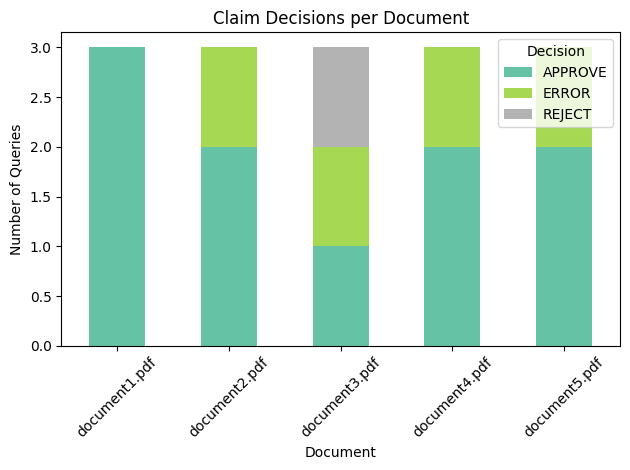

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame([
    {
        "Query": r["query"],
        "Document": r["document"],
        "Decision": r["decision"].get("decision", "ERROR"),
        "Amount": r["decision"].get("amount", 0),
        "Justification": r["decision"].get("justification", "N/A")
    }
    for r in results
])

# Decision counts
decision_counts = df.groupby(["Document", "Decision"]).size().unstack().fillna(0)

# 🔹 Bar Plot: Approve vs Reject per Document
decision_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Claim Decisions per Document")
plt.ylabel("Number of Queries")
plt.xlabel("Document")
plt.xticks(rotation=45)
plt.legend(title="Decision")
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import os
import json
import re
from sentence_transformers import SentenceTransformer
import torch
from groq import Groq
import fitz  # PyMuPDF

# Load Groq API key
os.environ["GROQ_API_KEY"] = ""  # Replace with your key
client = Groq(api_key=os.environ["GROQ_API_KEY"])

# SentenceTransformer
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Prompt templates
parse_prompt = """
You are an expert policy analyst.
Given an input query like:
"46-year-old male, knee surgery in Pune, 3-month-old insurance policy"
Extract the following fields:
- age (number)
- gender (M/F/Other)
- procedure (medical procedure)
- location (city)
- policy_duration_months (integer)
Return a JSON in the format:
{
  "age": ...,
  "gender": ...,
  "procedure": ...,
  "location": ...,
  "policy_duration_months": ...
}
"""

reason_prompt_template = """
You are an AI claim decision assistant.
Given a customer query and relevant policy clauses, make a claim decision.
Respond ONLY in the following JSON format:
{
  "decision": "APPROVE or REJECT",
  "amount": float,
  "justification": "Short reason mentioning the clause used"
}
"""

# Functions
def chunk_text(text, chunk_size=2000, overlap=200):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start += chunk_size - overlap
    return chunks

def embed_chunks(chunks):
    return embedder.encode(chunks, convert_to_tensor=True)

def search_similar_chunks(query, chunks, chunk_embeddings, top_k=3):
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = torch.nn.functional.cosine_similarity(query_embedding, chunk_embeddings)
    top_results = torch.topk(cos_scores, k=top_k)
    return [(chunks[i], float(cos_scores[i])) for i in top_results.indices]

def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    return "\n".join([page.get_text() for page in doc])

def parse_query(query):
    res = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": parse_prompt},
            {"role": "user", "content": query}
        ]
    )
    response_text = res.choices[0].message.content
    match = re.search(r'\{[\s\S]*?\}', response_text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return {"error": "Malformed JSON from Groq", "raw": response_text}
    else:
        return {"error": "No JSON object found", "raw": response_text}

def reason_over_chunks(parsed_query, matched_chunks):
    context = "\n\n".join([c for c, _ in matched_chunks])
    reasoning_input = f"Customer Info: {parsed_query}\n\nPolicy Clauses:\n{context}"
    res = client.chat.completions.create(
        model="llama3-8b-8192",
        messages=[
            {"role": "system", "content": reason_prompt_template},
            {"role": "user", "content": reasoning_input}
        ]
    )
    response_text = res.choices[0].message.content
    match = re.search(r'\{[\s\S]*?\}', response_text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return {"error": "Malformed JSON from Groq", "raw": response_text}
    else:
        return {"error": "No JSON object found", "raw": response_text}

# Streamlit App
st.title("🩺 Insurance Claim Evaluator (Groq + LLM)")

query = st.text_input("Enter your insurance claim query:")

pdf_file = st.file_uploader("Upload your policy PDF:", type="pdf")

if st.button("Submit") and query and pdf_file:
    with st.spinner("Reading policy and reasoning..."):
        with open("uploaded.pdf", "wb") as f:
            f.write(pdf_file.read())

        policy_text = extract_text_from_pdf("uploaded.pdf")
        parsed = parse_query(query)

        if "error" in parsed:
            st.error("❌ Query parsing failed")
            st.json(parsed)
        else:
            chunks = chunk_text(policy_text)
            embeddings = embed_chunks(chunks)
            matches = search_similar_chunks(query, chunks, embeddings)
            result = reason_over_chunks(parsed, matches)
            st.success("✅ Claim Decision:")
            st.json(result)


Writing app.py


In [ ]:
# How to get the APITOKEN
# 1. Sign up or log in to Ngrok
# Go to: https://dashboard.ngrok.com/signup

# 2. Get your Authtoken
# After login, go to: https://dashboard.ngrok.com/get-started/your-authtoken

# Copy the authtoken

In [ ]:
import os
from pyngrok import ngrok

# Replace with your actual token
!ngrok config add-authtoken ""


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
!streamlit run app.py &> /dev/null &  # silent run

# Open a tunnel to the Streamlit app
public_url = ngrok.connect(8501)
print("🔗 Streamlit app is live at:", public_url)


🔗 Streamlit app is live at: NgrokTunnel: "https://52be971ce9b5.ngrok-free.app" -> "http://localhost:8501"
